# Aim

Which are Netflix's Top 10 most popular shows of all time? How does the global audience for these titles compare to the greatest historic global TV broadcasts?

Netflix's [website](https://www.netflix.com/tudum/top10/most-popular) ranks its ten most popular shows based on viewing figures from the first 91 days of release.

In this analysis, we delve into the weekly global top 10 data to reveal new insights.

# Data Cleaning Process

We describe the processes undertaken to clean the three datasets downloaded from the Netflix website:

 - We set '*season_title*' to be '*show_title*' in cases where it has a null value
 - We set '*runtime*' to be *NA* where its value is *0*
 - We add unique identifiers

In [1]:
library(tidyverse)
library(lubridate)
library(dplyr)
library(knitr)
library(ggplot2)

# import the raw data
netflix_global_weekly <- read_tsv(
    "/kaggle/input/most-popular-netflix-shows/most-popular_global_weekly.tsv",
    show_col_types = FALSE)
netflix_global_alltime <- read_tsv(
    "/kaggle/input/most-popular-netflix-shows/most-popular_global_alltime.tsv",
    show_col_types = FALSE)
netflix_country_weekly <- read_tsv(
    "/kaggle/input/most-popular-netflix-shows/most-popular_country_weekly.tsv",
    show_col_types = FALSE)

# CLEANING THE DATA
# -----------------

cl_netflix_global_alltime <- netflix_global_alltime %>%
  mutate(season_title = ifelse(season_title == "N/A", show_title, season_title)) %>%
  mutate(runtime = ifelse(runtime == 0, NA_real_, runtime)) %>%  # replace runtimes of 0 with NA
  mutate(alltime_id = row_number()) %>%  # add a primary key
  select(alltime_id, everything())

cl_netflix_global_weekly <- netflix_global_weekly %>%
  mutate(season_title = ifelse(season_title == "N/A", show_title, season_title)) %>%
  mutate(runtime = ifelse(runtime == 0, NA_real_, runtime)) %>%  # replace runtimes of 0 with NA
  arrange(week) %>%
  mutate(weekly_id = row_number()) %>%  # add a primary key
  select(weekly_id, everything())

cl_netflix_country_weekly <- netflix_country_weekly %>%
  mutate(season_title = ifelse(season_title == "N/A", show_title, season_title)) %>%   # populate the season_title with show_title if it is currently "N/A"
  mutate(country_week_id = row_number()) %>%  # add a primary key
  select(country_week_id, everything())

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


 - We create separate reference tables for the show titles and season titles:

In [2]:
# create a reference table for shows/movies
netflix_show_titles <- cl_netflix_global_weekly %>%
  distinct(show_title) %>%
  arrange(show_title) %>%
  mutate(show_id = row_number()) %>%  # add a unique identifier
  select(show_id, show_title)

# create a reference table for season titles
netflix_season_titles <- cl_netflix_global_weekly %>%
  distinct(season_title, show_title) %>%
  arrange(season_title) %>%
  mutate(season_id = row_number()) %>% # add a unique identifier
  select(season_id, season_title, show_title)

# add show_title identifier to season reference table
netflix_season_titles <- netflix_season_titles %>%
  left_join(select(netflix_show_titles, show_title, show_id),
            by = "show_title",
            relationship = "many-to-many")

- We add foreign keys '*show_id*' and '*season_id*' to the cleaned versions of the datasets:

In [3]:
# add show_title and season_title identifiers to global weekly table
cl_netflix_global_weekly <- cl_netflix_global_weekly %>%
  left_join(select(netflix_show_titles, show_title, show_id),
            by = "show_title",
            relationship = "many-to-many") %>%
  left_join(select(netflix_season_titles, season_title, season_id),
            by = "season_title",
            relationship = "many-to-many")
  
# add show_title and season_title identifier to global alltime table
cl_netflix_global_alltime <- cl_netflix_global_alltime %>%
  left_join(select(netflix_show_titles, show_title, show_id),
            by = "show_title",
            relationship = "many-to-many") %>%
  left_join(select(netflix_season_titles, season_title, season_id),
            by = "season_title",
            relationship = "many-to-many")

# add show_title and season_title identifier to country weekly table
cl_netflix_country_weekly <- cl_netflix_country_weekly %>%
  left_join(select(netflix_show_titles, show_title, show_id),
            by = "show_title",
            relationship = "many-to-many") %>%
  left_join(select(netflix_season_titles, season_title, season_id),
            by = "season_title",
            relationship = "many-to-many")

 - We replace null '*runtime*' values in the cleaned version of **netflix_global_weekly** with '*runtime*' values from **netflix_global_alltime**

In [4]:
# update the runtime values in cl_netflix_global_weekly
cl_netflix_global_weekly <- cl_netflix_global_weekly %>%
  left_join(cl_netflix_global_alltime %>%
            select(season_id, runtime),
            by = "season_id") %>%
  mutate(runtime = ifelse(is.na(runtime.x), runtime.y, runtime.x)) %>%
  select(-runtime.x, -runtime.y)

- We note that some *season_title*s are missing from *netflix_global_weekly* (but are present in the 'alltime' dataset). This could be due to the title predating the weekly data or inconsistent use of show titles by Netflix.

# Data Transformation

We create three new variables:
 - total views whilst in the Global Top 10 ('*views_whilst_in_top_10*')
 - total hours viewed whilst in the Global Top 10 ('*hours_viewed_whilst_in_top_10*')
 - total days in the Global Top 10 ('*days_in_top_10*')

For comparison, we also add data for the *total views* and *total hours viewed* in the first 91 days of the title's release.

In [5]:
# create table with analysis of popularity based on weekly data
netflix_most_popular_season_titles <- cl_netflix_global_weekly %>%
  group_by(season_title) %>%
  summarize(
    days_in_top_10 = 7 * max(cumulative_weeks_in_top_10),
    first_week_in_top_10 = min(week),
    show_title = first(show_title),
    category = first(category),
    is_staggered_launch = first(is_staggered_launch),
    views_whilst_in_top_10 = sum(weekly_views),
    hours_viewed_whilst_in_top_10 = sum(weekly_hours_viewed),
    runtime = last(runtime),
    season_id = first(season_id),
    show_id = first(show_id)
      ) %>%
  select(
      season_title,
      show_title,
      runtime,
      category,
      first_week_in_top_10,
      days_in_top_10,
      views_whilst_in_top_10,
      hours_viewed_whilst_in_top_10,
      is_staggered_launch,
      season_id,
      show_id
  ) %>%

# add viewing data from alltime table
  left_join(select(cl_netflix_global_alltime, season_id, hours_viewed_first_91_days, views_first_91_days),
          by = "season_id",
          relationship = "many-to-many")

# Data Analysis

## Most Popular Netflix titles

Since the weekly number of views is often missing in the data, we will use viewing hours as the principal measure of a title's popularity.

In [6]:
# most popular titles (all categories) from weekly Top 10 data
most_popular_all_categories_weekly <- netflix_most_popular_season_titles %>%
  arrange(desc(hours_viewed_whilst_in_top_10)) %>%
  select(season_title,
         category,
         runtime,
         first_week_in_top_10,
         days_in_top_10,
         hours_viewed_whilst_in_top_10,
         hours_viewed_first_91_days,
         is_staggered_launch,
         season_id
         )
most_popular_all_categories_weekly <- head(most_popular_all_categories_weekly, 10)
kable(
    most_popular_all_categories_weekly %>%
    select(season_title, days_in_top_10, hours_viewed_whilst_in_top_10, hours_viewed_first_91_days),      
      caption = "Most Popular Titles from weekly Global Top 10 data"
)



Table: Most Popular Titles from weekly Global Top 10 data

|season_title                              | days_in_top_10| hours_viewed_whilst_in_top_10| hours_viewed_first_91_days|
|:-----------------------------------------|--------------:|-----------------------------:|--------------------------:|
|Squid Game: Season 1                      |            182|                    2580300000|                 2205200000|
|Stranger Things 4                         |            133|                    1887310000|                 1838000000|
|Wednesday: Season 1                       |            140|                    1806850000|                 1718800000|
|Squid Game: Season 2                      |             21|                    1093000000|                 1093000000|
|Bridgerton: Season 2                      |            154|                    1027000000|                  797200000|
|DAHMER: Monster: The Jeffrey Dahmer Story |             49|                     962470000|        

In [7]:
most_popular_all_categories_alltime <- netflix_most_popular_season_titles %>%
  arrange(desc(hours_viewed_first_91_days)) %>%
  select(season_title,
         category,
         runtime,
         days_in_top_10,
         hours_viewed_whilst_in_top_10,
         hours_viewed_first_91_days,
         season_id
  )
most_popular_all_categories_alltime <- head(most_popular_all_categories_alltime, 10)
kable(
    most_popular_all_categories_alltime %>%
    select(season_title, hours_viewed_first_91_days),
    caption = "Most Popular Titles from first 91 days data"
)



Table: Most Popular Titles from first 91 days data

|season_title                              | hours_viewed_first_91_days|
|:-----------------------------------------|--------------------------:|
|Squid Game: Season 1                      |                 2205200000|
|Stranger Things 4                         |                 1838000000|
|Wednesday: Season 1                       |                 1718800000|
|Squid Game: Season 2                      |                 1093000000|
|DAHMER: Monster: The Jeffrey Dahmer Story |                 1031100000|
|Bridgerton: Season 1                      |                  929300000|
|Money Heist: Part 5                       |                  900700000|
|Bridgerton: Season 3                      |                  846500000|
|The Night Agent: Season 1                 |                  803200000|
|Bridgerton: Season 2                      |                  797200000|

Our analysis of the weekly Global Top 10 data produces the same four most popular titles as Netflix's so-called 'all time' data based on the first 91 days.

However we record marginally higher viewing hours - consistent with the fact that the most popular titles stay in the Global Top 10 for more than 91 days.

 - **Squid Game: Season 1** was in the Global Top 10 for 182 days and recorded **2.58 billion** viewing hours
 - **Stranger Things 4** was in the Global Top 10 for 133 days and recorded **1.89 billion** viewing hours
 - **Wednesday: Season 1** was in the Global Top 10 for 140 days and recorded **1.81 billion** viewing hours
 - **Squid Game: Season 2** was in the Global Top 10 for 21 days and recorded **1.09 billion** viewing hours

So how do these figures compare with historic global TV broadcasts?

## Historic Global TV Broadcasts

The **2008 Beijing Summer Olympics Opening Ceremony** is generally regarded as the 'most watched event in human history'. It lasted approximately 4 hours and was seen by an average audience of [593 million](https://www.thetimes.com/article/1000000000-beijing-sets-world-tv-record-6c6958vcwqk) equating to **2.37 billion** viewing hours.

The **Apollo 11 Moonwalk** on 20 July 1969 when astronaut Neil Armstrong famously uttered the words “one small step for a man, one giant leap for mankind" lasted [2 hours 31 minutes](https://www.nasa.gov/wp-content/uploads/static/history/alsj/a11/a11_missionreport.pdf) and was watched by an estimated global audience of [650 million](https://www.nasa.gov/missions/apollo-11-mission-overview) equating to a maximum of **1.63 billion** viewing hours. (Although many billions have since watched the footage in documentaries and on YouTube, the short duration of clips means the overall tally of viewing hours is unlikely to be substantially changed.)

Based on this analysis, we can conclude that humanity has spent more time watching Netflix's **Squid Game: Season 1** than the Apollo 11 moon landing or the Opening Ceremony of the Beijing Olympics.

png 
  2

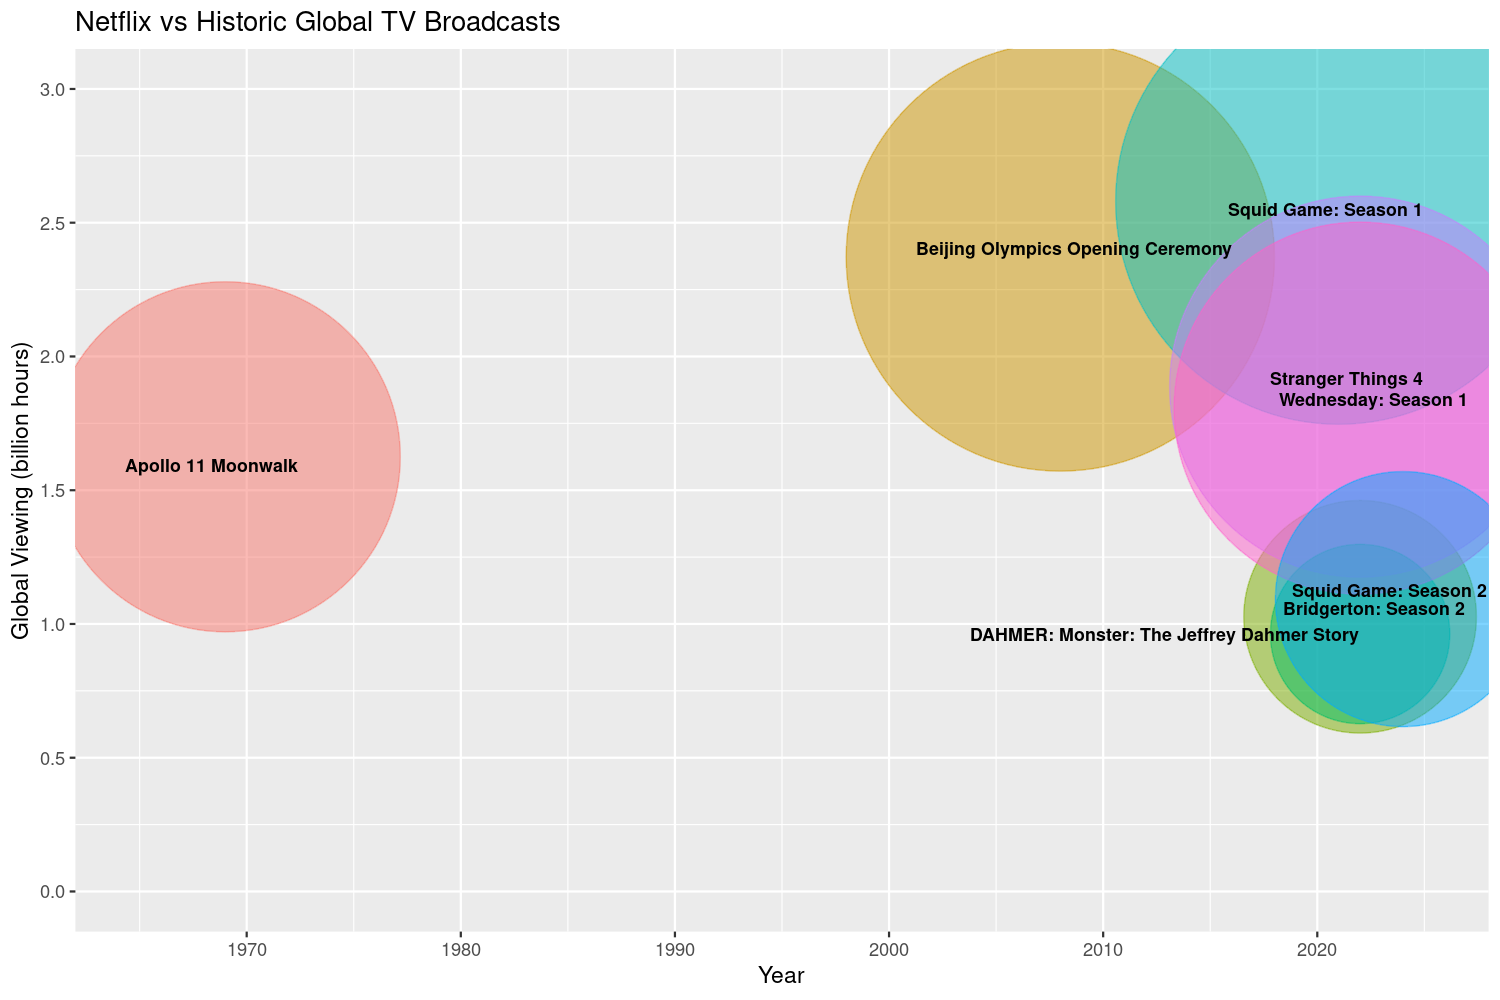

In [8]:
library(ggrepel)

# Bubble Plot: Humanity Netflix Viewing
n <- 6 # number of Netflix titles on Bubble Plot
top_n_with_historical_comparison <- most_popular_all_categories_weekly %>%
  slice(1:n)  %>%
  add_row(season_title = "Apollo 11 Moonwalk",
          category = "TV (English)",
          runtime = 2.5,
          first_week_in_top_10 = as.Date("1969-07-20"),
          hours_viewed_whilst_in_top_10 = 650000000 * 2.5,
          hours_viewed_first_91_days = 650000000 * 2.5
          )   %>%
  add_row(season_title = "Beijing Olympics Opening Ceremony",
          category = "TV (Non-English)",
          runtime = 4.0,
          first_week_in_top_10 = as.Date("2008-08-08"),
          hours_viewed_whilst_in_top_10 = 593000000 * 4,
          hours_viewed_first_91_days = 593000000 * 4
          )   %>%
  arrange(first_week_in_top_10)

# bubble plot
png("netflix_historic_comparisons.png", width = 1500, height = 1000, res = 150)
options(repr.plot.width = 15, repr.plot.height = 10)
ggplot(top_n_with_historical_comparison,
       aes(x=year(first_week_in_top_10),
           y=hours_viewed_whilst_in_top_10/1000000000,
           size = hours_viewed_whilst_in_top_10,
           color = season_title)) +
geom_point(alpha=0.5) +
geom_text_repel(aes(label = season_title), size = 3, box.padding = 0, color = "black", fontface = "bold") +
scale_size(range = c(40, 100), name="Population (M)") +
scale_y_continuous(
        limits = c(0, 3),
        breaks = seq(0, 3, 0.5)
    ) +
scale_x_continuous(
        limits = c(1965, 2025),
        breaks = seq(1950, 2040, 10)
    ) +
labs(
    title = "Netflix vs Historic Global TV Broadcasts",
        x = "Year",
        y = "Global Viewing (billion hours)",
    color = "Season Title"
) +
theme(legend.position = "none")
dev.off()

library(IRdisplay)
display_png(file = "netflix_historic_comparisons.png")

## The mystery of Stranger Things 4

The weekly data allows us to explore how the most popular titles perform whilst in Netflix's Global Top 10.

png 
  2

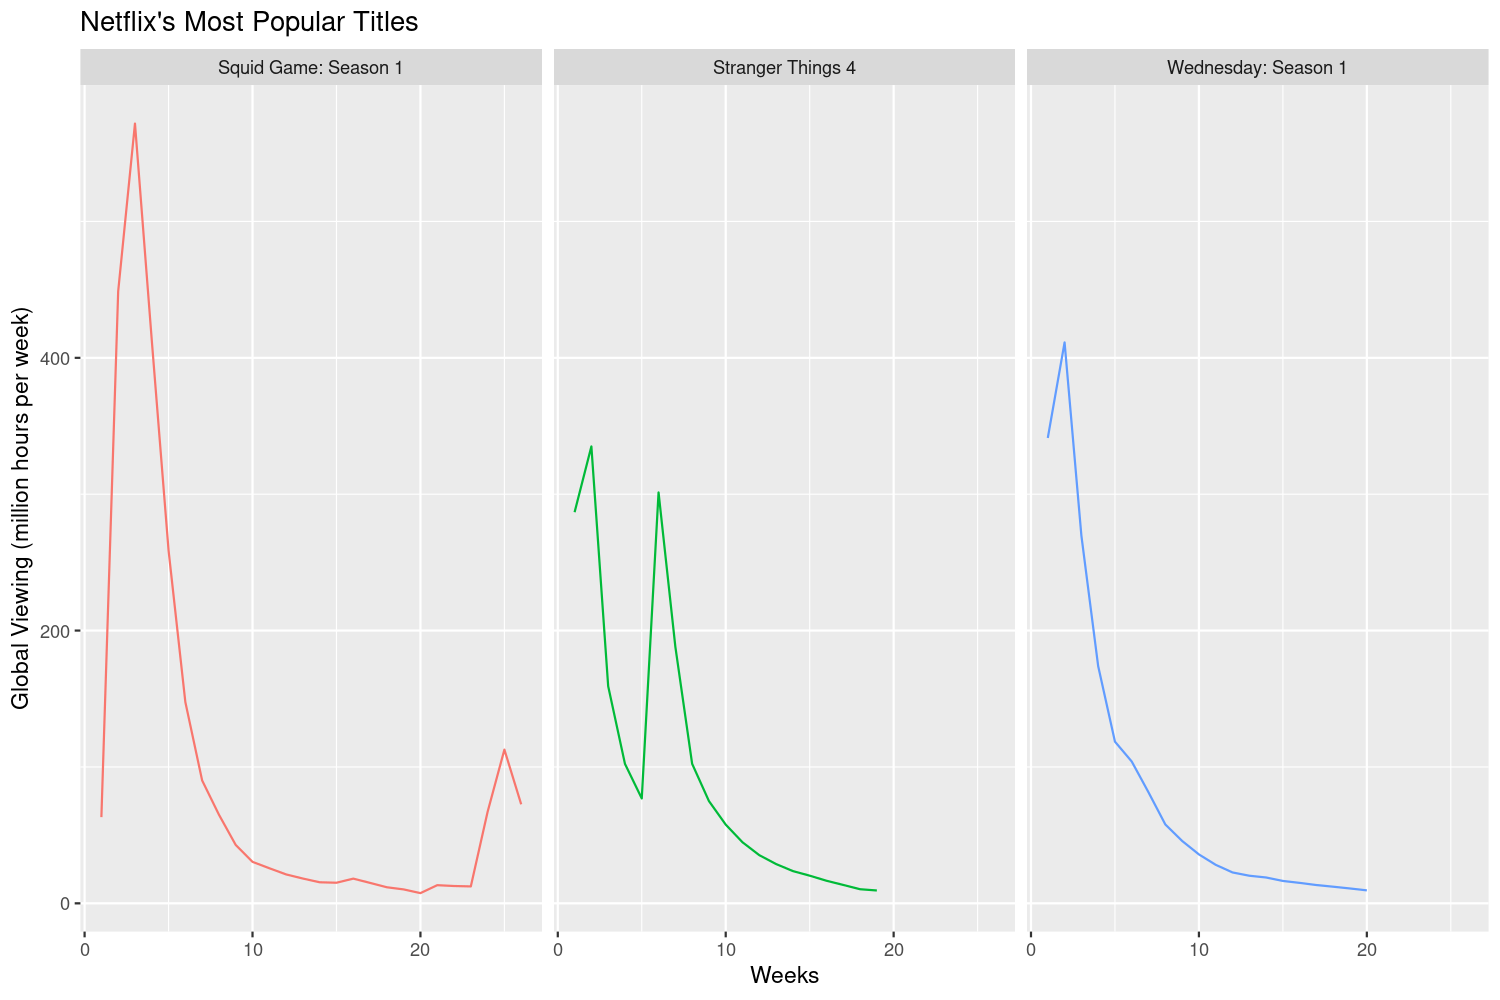

In [9]:
# NETFLIX TOP N GRAPHS
top_n_titles <- most_popular_all_categories_weekly %>%
  slice_head(n = 3)

netflix_top_n_graphs <- cl_netflix_global_weekly %>%
  inner_join(select(top_n_titles, season_id),
            by = "season_id")

png("netflix_most_popular_titles.png", width = 1500, height = 1000, res = 150)
options(repr.plot.width = 15, repr.plot.height = 7)
ggplot(data=netflix_top_n_graphs) +
  geom_line(mapping=aes(x=cumulative_weeks_in_top_10, y=weekly_hours_viewed/1000000, color=season_title)) +
  facet_grid(~season_title) +
  theme(legend.position = "none") +
  labs(title = "Netflix's Most Popular Titles",
       x = "Weeks",
       y = "Global Viewing (million hours per week)")
dev.off()

library(IRdisplay)
display_png(file = "netflix_most_popular_titles.png")

Peak viewing generally occurs within the first few weeks of release. However **Stranger Things 4** has an unusual curve - with a dramatic dip before spiking again.

We will explore the Netflix datasets to see if we can find an explanation.

png 
  2

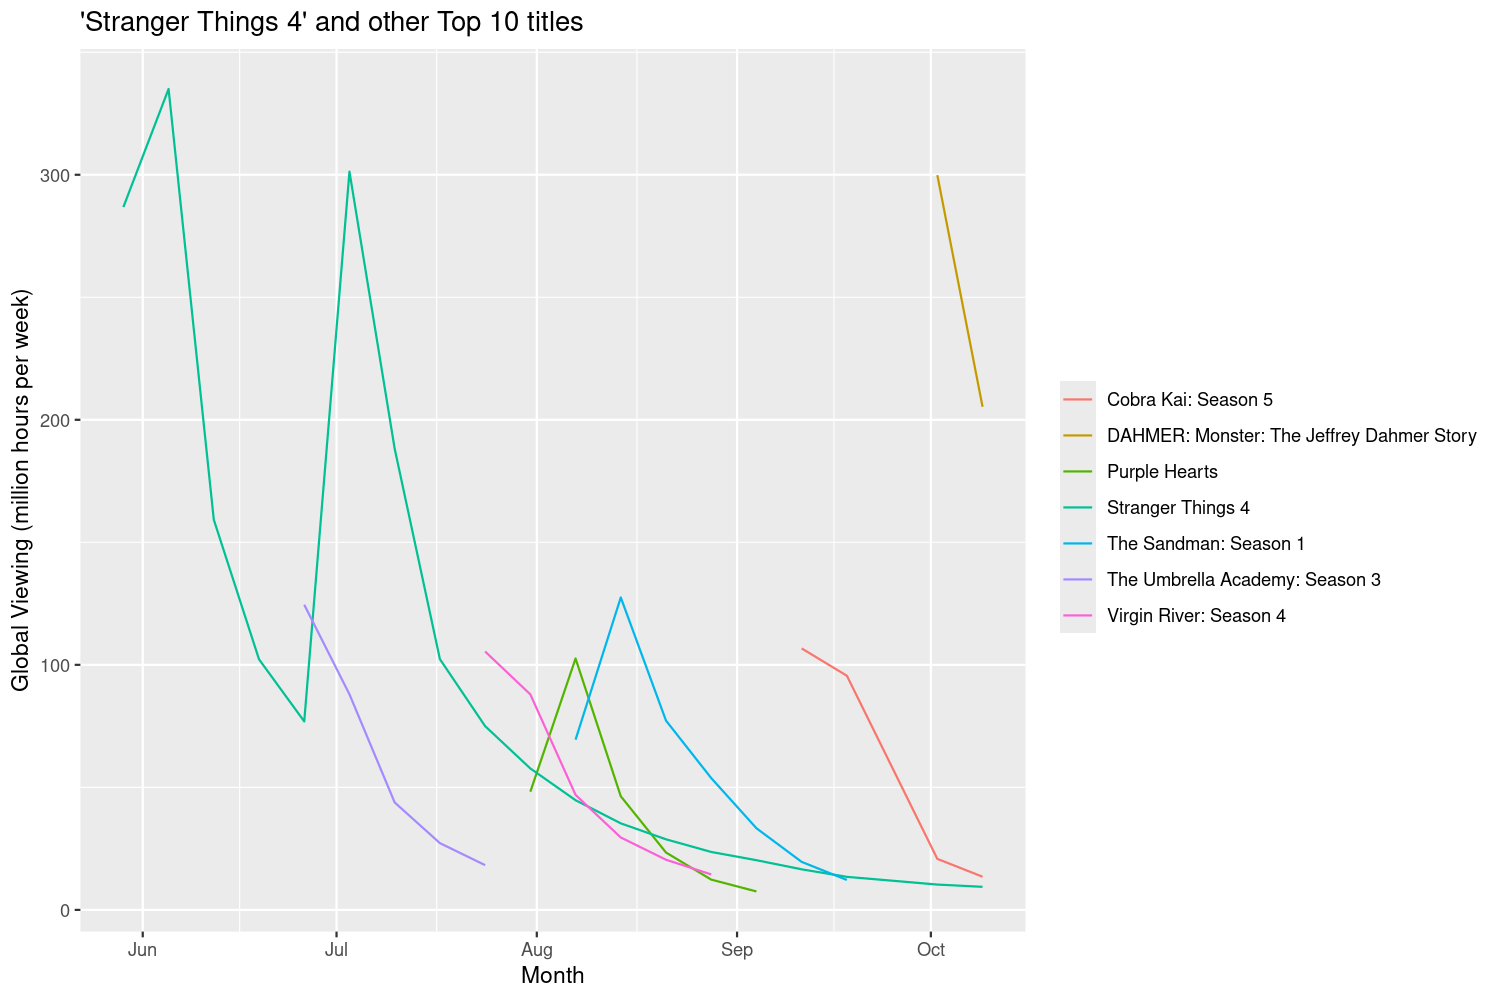

In [10]:
# STRANGER THINGS 4
# compile weekly viewing data for the weeks that Stranger Things 4 was in the Top 10
stranger_things_4_graph <- cl_netflix_global_weekly %>%
  inner_join(
    cl_netflix_global_weekly %>%
      filter(season_title == "Stranger Things 4") %>%
      select(week),
    by = "week")  %>%
  arrange(season_title)

# filter out titles that achieved less than 100 million hours weekly views
fltd_stranger_things_4_graph <- stranger_things_4_graph %>%
  right_join(
    stranger_things_4_graph %>%
      filter(weekly_hours_viewed > 100000000) %>%
      select(season_id) %>%
    distinct(),
    by = "season_id"
    )  %>%
  arrange(season_title)

# plot the graph
png("stranger_things_4.png", width = 1500, height = 1000, res = 150)
options(repr.plot.width = 15, repr.plot.height = 7)
ggplot(data=fltd_stranger_things_4_graph) +
  geom_line(mapping = aes(x = week, y = weekly_hours_viewed/1000000, color = season_title)) +
  labs(title = "'Stranger Things 4' and other Top 10 titles",
       x = "Month",
       y = "Global Viewing (million hours per week)",
       color = "")
dev.off()

library(IRdisplay)
display_png(file = "stranger_things_4.png")

We observe that the dip in viewing roughly coincides with the release of **The Umbrella Academy: Season 3** in late June 2022.

Linking to GEOS 3.10.2, GDAL 3.4.1, PROJ 8.2.1; sf_use_s2() is TRUE



png 
  2

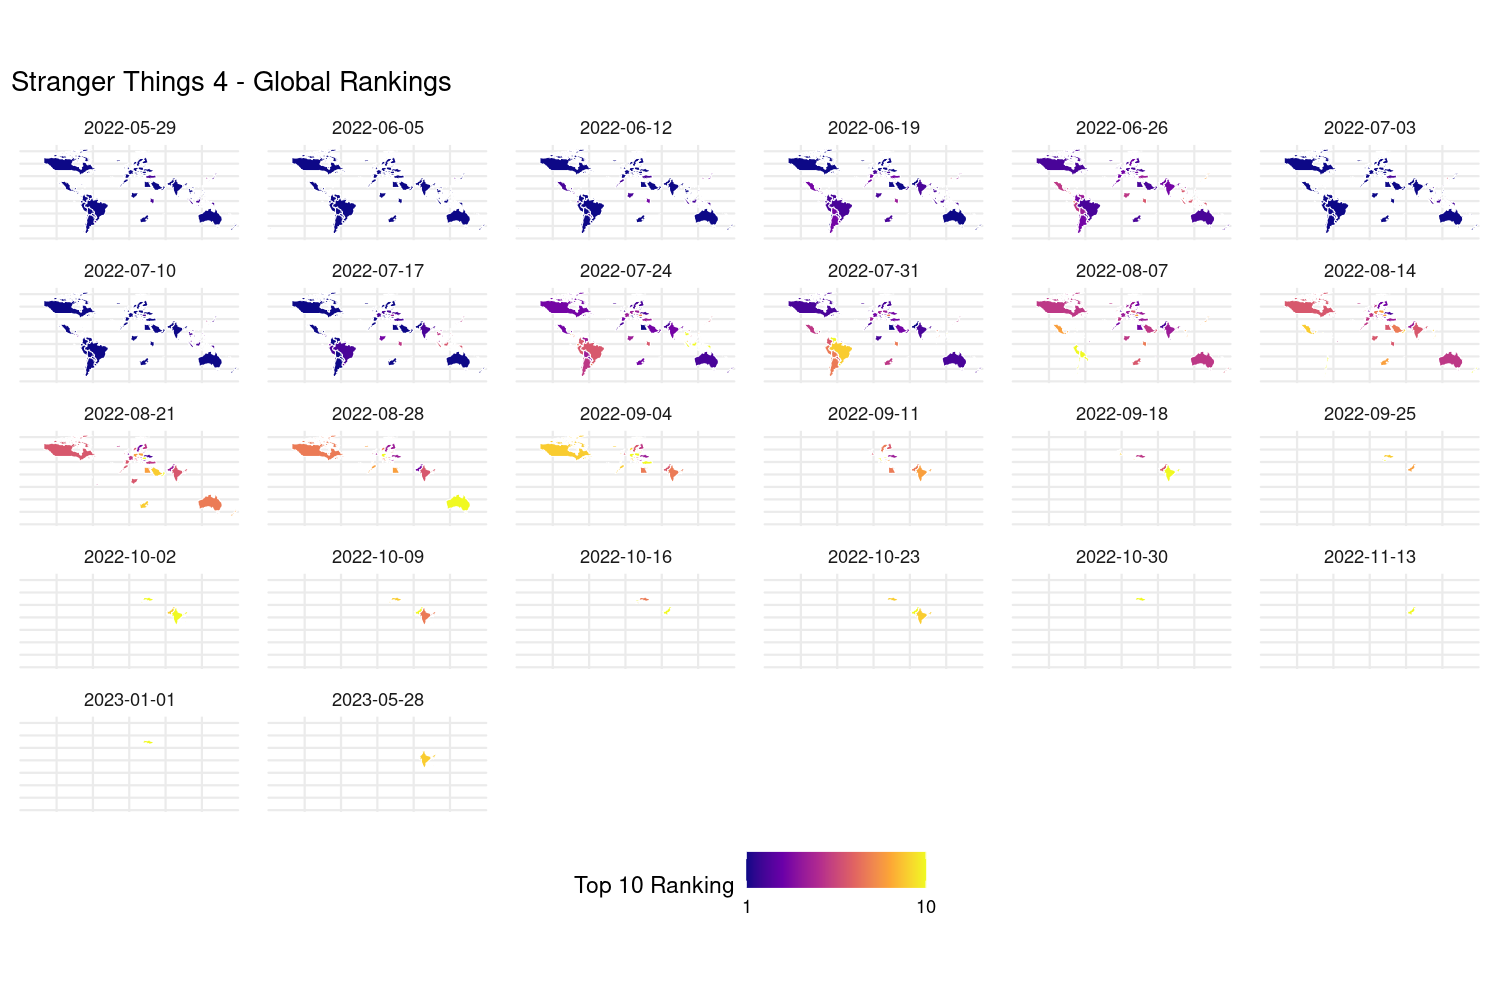

In [11]:
library(rnaturalearth)
library(sf)
world <- ne_countries(scale = "medium", returnclass = "sf")

# STRANGER THINGS 4
# Filter data
stranger_things_4_country_weekly <- cl_netflix_country_weekly %>%
  filter(season_title == 'Stranger Things 4')

# Prepare data for mapping
plot_data <- stranger_things_4_country_weekly %>%
  rename(country = country_name) %>%
  select(country, week, weekly_rank) %>%
  group_by(country, week) %>%
  summarise(weekly_rank = mean(weekly_rank, na.rm = TRUE), .groups = "drop") %>%
  mutate(country = tolower(country))  # Standardize country names

map_data <- world %>%
  mutate(country = tolower(name)) %>%  # Standardize map country names
  left_join(plot_data, by = "country")  %>% # Complete the chain here
  filter(!is.na(week))

# Plot the map
png("stranger_things_4_global.png", width = 1500, height = 1000, res = 150)
options(repr.plot.width = 15, repr.plot.height = 10)
ggplot(map_data) +
  geom_sf(mapping = aes(fill = weekly_rank), color = "white") +
  scale_fill_viridis_c(
    option = "plasma",
    na.value = "gray90",
    breaks = c(1, 10),
    labels = c("1", "10")
  ) +
  theme_minimal() +
  labs(title = "Stranger Things 4 - Global Rankings", fill = "Top 10 Ranking") +
  theme(
    axis.text = element_blank(),
    legend.position = "bottom",
    legend.direction = "horizontal"
  ) +
  facet_wrap(~ week)
dev.off()

library(IRdisplay)
display_png(file = "stranger_things_4_global.png")

png 
  2

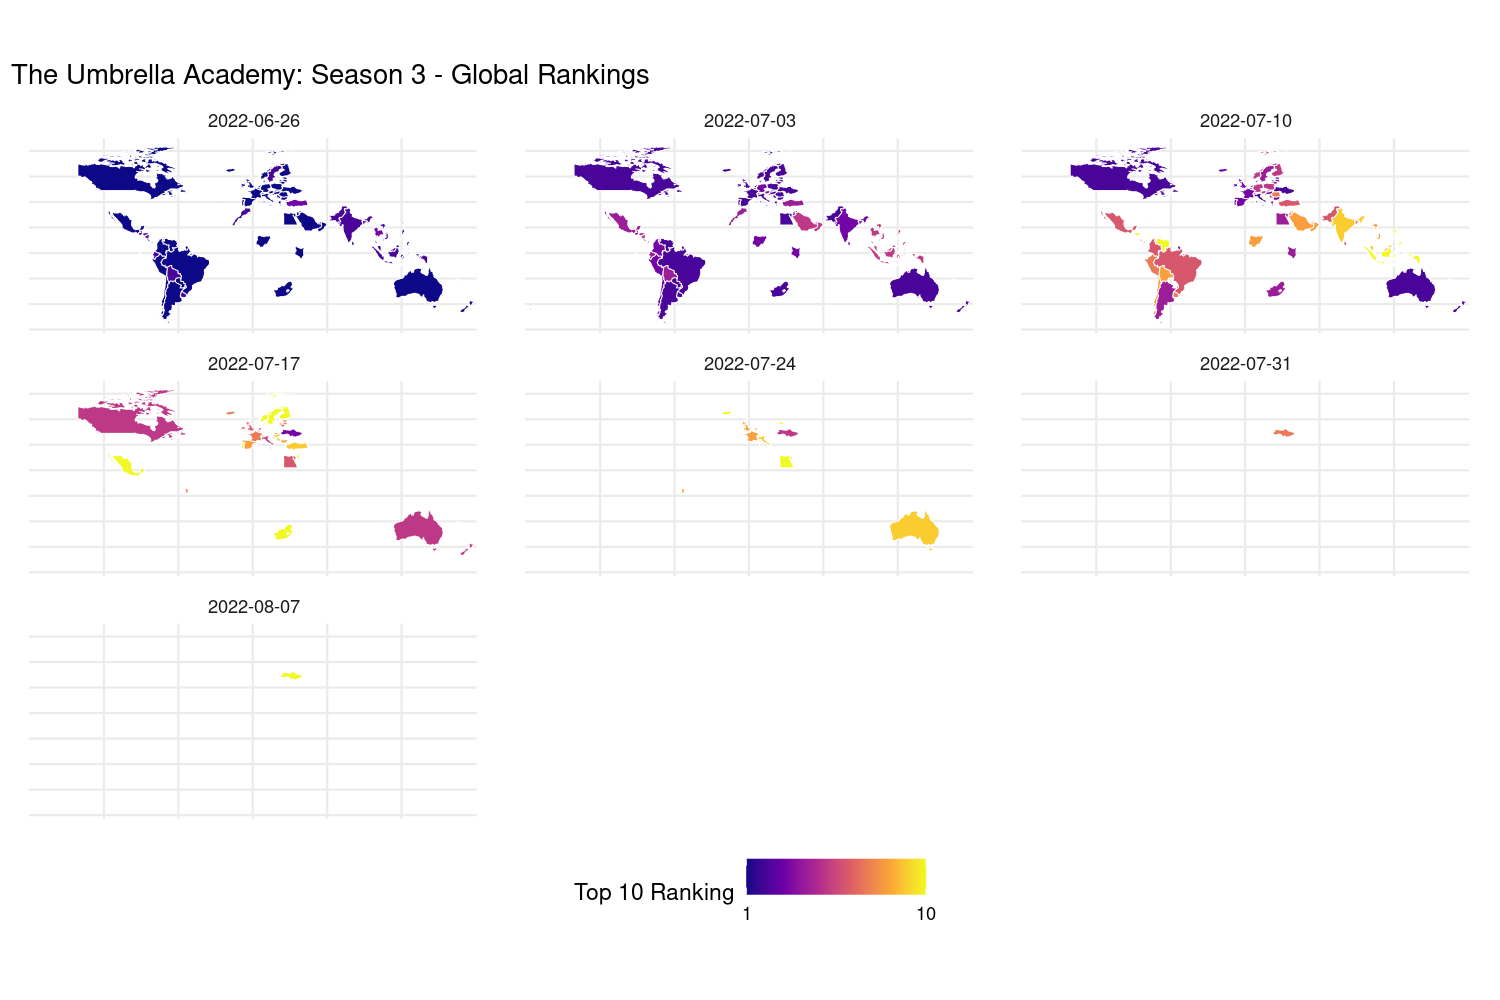

In [12]:
# THE UMBRELLA ACADEMY
# Filter data
umbrella_academy_country_weekly <- cl_netflix_country_weekly %>%
  filter(season_title == 'The Umbrella Academy: Season 3')

# Prepare data for mapping
plot_data2 <- umbrella_academy_country_weekly %>%
  rename(country = country_name) %>%
  select(country, week, weekly_rank) %>%
  group_by(country, week) %>%
  summarise(weekly_rank = mean(weekly_rank, na.rm = TRUE), .groups = "drop") %>%
  mutate(country = tolower(country))

map_data <- world %>%
  mutate(country = tolower(name)) %>%  # Standardize map country names
  left_join(plot_data2, by = "country")  %>% # Complete the chain here
  filter(!is.na(week))

# Plot the map
png("umbrella_academy_3_global.png", width = 1500, height = 1000, res = 150)
options(repr.plot.width = 15, repr.plot.height = 10)
ggplot(map_data) +
  geom_sf(mapping = aes(fill = weekly_rank), color = "white") +
  scale_fill_viridis_c(
    option = "plasma",
    na.value = "gray90",
    breaks = c(1, 10),
    labels = c("1", "10")
  ) +
  theme_minimal() +
  labs(title = "The Umbrella Academy: Season 3 - Global Rankings", fill = "Top 10 Ranking") +
  theme(
    axis.text = element_blank(),
    legend.position = "bottom",
    legend.direction = "horizontal"
  ) +
  facet_wrap(~ week)
dev.off()

library(IRdisplay)
display_png(file = "umbrella_academy_3_global.png")

The plots show that the dip in viewing for **Stranger Things 4**'s is particularly pronounced in South America.

However, our analysis suggests there were several contributing factors:

png 
  2

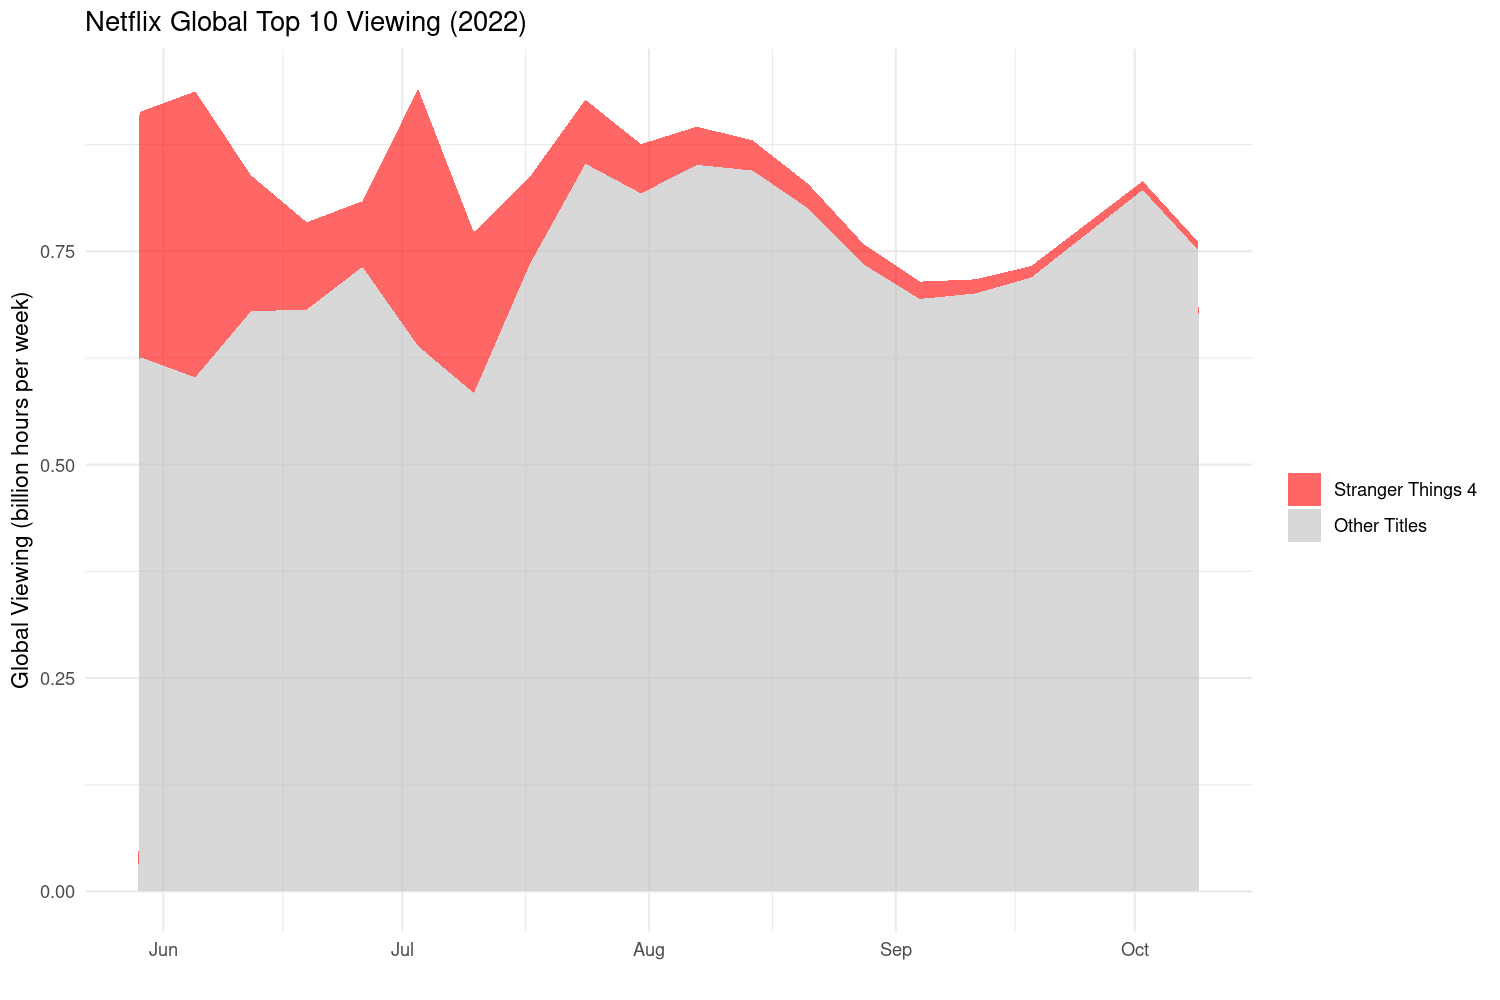

In [13]:
#compile total weekly viewings during 'Stranger Things 4' Top 10 weeks
netflix_total_weekly_top_10_viewing <- cl_netflix_global_weekly %>%
  group_by(week) %>%
  summarize(total_weekly_hours_viewed = sum(weekly_hours_viewed)) %>%
  select(week, total_weekly_hours_viewed)

stranger_things_top_10_viewing <- cl_netflix_global_weekly %>%
  filter(season_title == 'Stranger Things 4') %>%
  rename(stranger_things_weekly_hours_viewed = weekly_hours_viewed) %>%
  select(week, stranger_things_weekly_hours_viewed)  %>%
  left_join(netflix_total_weekly_top_10_viewing, by = "week") %>%
  mutate(z_other_weekly_hours_viewed = total_weekly_hours_viewed - stranger_things_weekly_hours_viewed)

#turn into long table
data_long <- stranger_things_top_10_viewing %>%
  pivot_longer(
    cols = c(z_other_weekly_hours_viewed, stranger_things_weekly_hours_viewed),  # Columns to reshape
    names_to = "viewing_type",  # New column for viewing type
    values_to = "viewing"  # New column for values
  )

png("netflix_top_10_viewing_summer_2022.png", width = 1500, height = 1000, res = 150)
ggplot(data_long, aes(x = week, y = viewing/1000000000, fill = viewing_type, group = viewing_type)) +
  geom_area(alpha = 0.6) +  # Add area plots with some transparency
  labs(
    title = "Netflix Global Top 10 Viewing (2022)",
    x = "",
    y = "Global Viewing (billion hours per week)",
    fill = ""  # Set the legend title
  ) +
  scale_fill_manual(
    values = c("stranger_things_weekly_hours_viewed" = "red", "z_other_weekly_hours_viewed" = "grey"),  # Customize colors
    labels = c("Stranger Things 4", "Other Titles")  # Rename the legend items
  ) +
  theme_minimal()
dev.off()

library(IRdisplay)
display_png(file = "netflix_top_10_viewing_summer_2022.png")

It is noted that there was a significant decline in the overall global Netflix audience for Top 10 shows in mid to late June - meaning that the release of **The Umbrella Academy: Season 3** cannot be the sole cause for the dip in **Stranger Things 4**'s audience.

Searching the internet, we find that this period coincided with major televised sportings events, including several FIFA World Cup qualifying matches:
* June 13, 2022: Australia vs. Peru
* June 14, 2022: Costa Rica vs. New Zealand
* June 17–19, 2022: CONIFA South America Football Cup

We propose that these sporting events, combined with the release of **The Umbrella Academy: Season 3**, caused the dramatic dip in the **Stranger Things 4** audience.